In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

In [ ]:
%ls ./data/processed

# T1H-X1700M-Y1760M/  T24H-X850M-Y880M/  T3H-X850M-Y880M/
# T12H-X850M-Y880M/  T24H-X425M-Y440M/   T24H-X85M-Y110M/   T6H-X850M-Y880M/

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult
from utils.mock_data import mock_data

In [2]:
data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  # needs to exist
model_name = "FNN-CRIME-MODEL"  # needs to be created

data_path = f"./data/processed/{data_dim_str}/"
model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": False,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.2,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type

# GET DATA

data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

2019-10-18T21:08:54 | root | INFO | =====================================BEGIN=====================================
2019-10-18T21:08:54 | root | INFO | Device: cpu
2019-10-18T21:08:54 | root | INFO | Data shapes of files in generated_data.npz
2019-10-18T21:08:54 | root | INFO | 	crime_feature_indices shape (11,)
2019-10-18T21:08:54 | root | INFO | 	crime_types_grids shape (365, 11, 47, 33)
2019-10-18T21:08:54 | root | INFO | 	crime_grids shape (365, 1, 47, 33)
2019-10-18T21:08:54 | root | INFO | 	demog_grid shape (1, 37, 47, 33)
2019-10-18T21:08:54 | root | INFO | 	street_grid shape (1, 512, 47, 33)
2019-10-18T21:08:54 | root | INFO | 	time_vectors shape (366, 52)
2019-10-18T21:08:54 | root | INFO | 	weather_vectors shape (365, 11)
2019-10-18T21:08:54 | root | INFO | 	x_range shape (33,)
2019-10-18T21:08:54 | root | INFO | 	y_range shape (47,)
2019-10-18T21:08:54 | root | INFO | 	t_range shape (366,)
shape crimes_train ->  (256, 1, 763)
shape crimes ->  (364, 1, 763)


# ---------------------------- TESTING START ----------------------------

In [3]:
class MockLoaders:
    def __init__(self, train_loader=None, validation_loader=None, test_loader=None):
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.test_loader = test_loader
    

class MockLoader:
    def __init__(self, vector_size, batch_size, n_samples, class_split):
        n_feats = np.sum(vector_size)
        X, y = mock_data(n_samples=n_samples, n_feats=n_feats, class_split=class_split)
                
        y = np.expand_dims(y, axis=1)
        y = np.expand_dims(y, axis=0)
        X = np.expand_dims(X, axis=0)
        
        indices = np.expand_dims(np.arange(n_samples), axis=0)
        indices = np.expand_dims(indices, axis=2)
        
        vectors = [indices]
        i = 0
        for j in vector_size:
            vectors.append(X[:,:,i:i+j])
            i += j
        vectors.append(y)    
        
        self.n_samples = n_samples
        self.n_feats = n_feats
        self.vectors = vectors
        self.batch_size = batch_size
        self.num_batches = int(np.ceil(self.n_samples / self.batch_size))
        self.current_batch = 0
        
        
        self.max_index = n_samples
        self.min_index = 0
        self.dataset = self # just to act as an interface
   
    def __len__(self):
        return self.n_samples

    def __iter__(self):
        self.current_batch = 0
        return self

    def __next__(self):
        if self.current_batch >= self.num_batches:
            raise StopIteration
        else:
            self.current_batch += 1
            start_index = (self.current_batch - 1) * self.batch_size
            stop_index = self.current_batch * self.batch_size
            if stop_index > len(self):
                stop_index = len(self)
            return self[start_index:stop_index]
        
            
    def __getitem__(self, index):        
        return tuple(map(lambda x: x[:,index], self.vectors))
    
vector_size= [3,6,13]#[37,65,512]
batch_size = 100    
class_split=0.5
train_loader = MockLoader(vector_size, batch_size, n_samples=7000, class_split=class_split)
validation_loader = MockLoader(vector_size, batch_size, n_samples=1000, class_split=class_split)
test_loader = MockLoader(vector_size, batch_size, n_samples=2000, class_split=class_split)
loaders = MockLoaders(train_loader,validation_loader,test_loader)

In [4]:
# test with pytorch linear model

In [5]:
class MLP(nn.Module):
    """
    MLP Classifier
    """
    # todo add layers functinality with hidden size
    def __init__(self, input_size=100, hidden_size=100, n_classes=2):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_classes = n_classes
        
        self.model = nn.Sequential(nn.Linear(input_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, n_classes))

    def forward(self, x):
        return self.model(x)

class SimpleFNN(nn.Module):
    """
    MLP Classifier
    """
    # todo add layers functinality with hidden size
    def __init__(self, input_size=100, hidden_size=100, n_classes=2):
        super(SimpleFNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_classes = n_classes
        
        self.model = nn.Sequential(nn.Linear(input_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, n_classes))

    def forward(self, spc_vec, tmp_vec, env_vec):
        cat_vec = torch.cat([spc_vec, tmp_vec, env_vec], dim=-1)
        out_vec = self.model(cat_vec)
        
        return out_vec
        
class KangFeedForwardNetwork(nn.Module):
    def __init__(self, spc_size=37, tmp_size=15, env_size=512, dropout_p=0.5):
        super(KangFeedForwardNetwork, self).__init__()

        self.dropout_p = dropout_p
        self.dropout = nn.Dropout(p=self.dropout_p)

        self.spcNet = nn.Sequential(nn.Linear(spc_size, 256),
                                    nn.ReLU(), 
                                    nn.Linear(256, 256), 
                                    nn.ReLU(),
                                    nn.Linear(256, 128), 
                                    nn.ReLU())
        self.tmpNet = nn.Sequential(nn.Linear(tmp_size, 256), 
                                    nn.ReLU(), nn.Linear(256, 256), 
                                    nn.ReLU(),
                                    nn.Linear(256, 128), 
                                    nn.ReLU())
        
        self.envNet = nn.Sequential(nn.Linear(env_size, 256), 
                                    nn.ReLU(), 
                                    nn.Linear(256, 256), 
                                    nn.ReLU(),
                                    nn.Linear(256, 128), 
                                    nn.ReLU())
        
        self.finalNet = nn.Sequential(nn.Linear(384, 1024), 
                                      nn.ReLU(), 
                                      nn.Linear(1024, 1024), 
                                      nn.ReLU(),
                                      nn.Linear(1024, 2))

    def forward(self, spc_vec, tmp_vec, env_vec):
        if self.dropout_p > 0:
            spc_vec = self.dropout(spc_vec)
            tmp_vec = self.dropout(tmp_vec)
            env_vec = self.dropout(env_vec)

        mid_vec = torch.cat([self.spcNet(spc_vec), self.tmpNet(tmp_vec), self.envNet(env_vec)], dim=-1)
        out_vec = self.finalNet(mid_vec)

        return out_vec  
    
class SmallKangFNN(nn.Module):
    def __init__(self, spc_size=37, tmp_size=15, env_size=512, dropout_p=0.5):
        super(SmallKangFNN, self).__init__()

        self.dropout_p = dropout_p
        self.dropout = nn.Dropout(p=self.dropout_p)

        self.spcNet = nn.Sequential(nn.Linear(spc_size, 50),
                                    nn.ReLU(), 
                                    nn.Linear(50, 10), 
                                    nn.ReLU())
        self.tmpNet = nn.Sequential(nn.Linear(tmp_size, 50), 
                                    nn.Linear(50, 10), 
                                    nn.ReLU())
        
        self.envNet = nn.Sequential(nn.Linear(env_size, 50), 
                                    nn.ReLU(),
                                    nn.Linear(50, 10), 
                                    nn.ReLU())
        
        self.finalNet = nn.Sequential(nn.Linear(30, 10), 
                                      nn.ReLU(),
                                      nn.Linear(10, 2))

    def forward(self, spc_vec, tmp_vec, env_vec):
        if self.dropout_p > 0:
            spc_vec = self.dropout(spc_vec)
            tmp_vec = self.dropout(tmp_vec)
            env_vec = self.dropout(env_vec)

        mid_vec = torch.cat([self.spcNet(spc_vec), self.tmpNet(tmp_vec), self.envNet(env_vec)], dim=-1)
        out_vec = self.finalNet(mid_vec)

        return out_vec      

In [39]:
import logging
# turn off logging
logging.getLogger().setLevel("INFO")

# todo custom parameters with unique learning rates that can be switches on and off during training - same with drop_out

2019-10-18T22:00:20 | root | INFO | Epoch: 0001/0020
2019-10-18T22:00:20 | root | INFO | \learning rate: 	0.00100
2019-10-18T22:00:20 | root | INFO | 	Loss (Trn): 	0.67594
2019-10-18T22:00:20 | root | INFO | 	Loss (Val): 	0.63162
2019-10-18T22:00:20 | root | INFO | 	Loss (Dif): 	0.04432

2019-10-18T22:00:20 | root | INFO | Epoch: 0002/0020
2019-10-18T22:00:20 | root | INFO | \learning rate: 	0.00100
2019-10-18T22:00:20 | root | INFO | 	Loss (Trn): 	0.49872
2019-10-18T22:00:20 | root | INFO | 	Loss (Val): 	0.31046
2019-10-18T22:00:20 | root | INFO | 	Loss (Dif): 	0.18826

2019-10-18T22:00:20 | root | INFO | Epoch: 0003/0020
2019-10-18T22:00:20 | root | INFO | \learning rate: 	0.00100
2019-10-18T22:00:20 | root | INFO | 	Loss (Trn): 	0.21134
2019-10-18T22:00:20 | root | INFO | 	Loss (Val): 	0.13643
2019-10-18T22:00:20 | root | INFO | 	Loss (Dif): 	0.07491

2019-10-18T22:00:20 | root | INFO | Epoch: 0004/0020
2019-10-18T22:00:20 | root | INFO | \learning rate: 	0.00100
2019-10-18T22:00:20

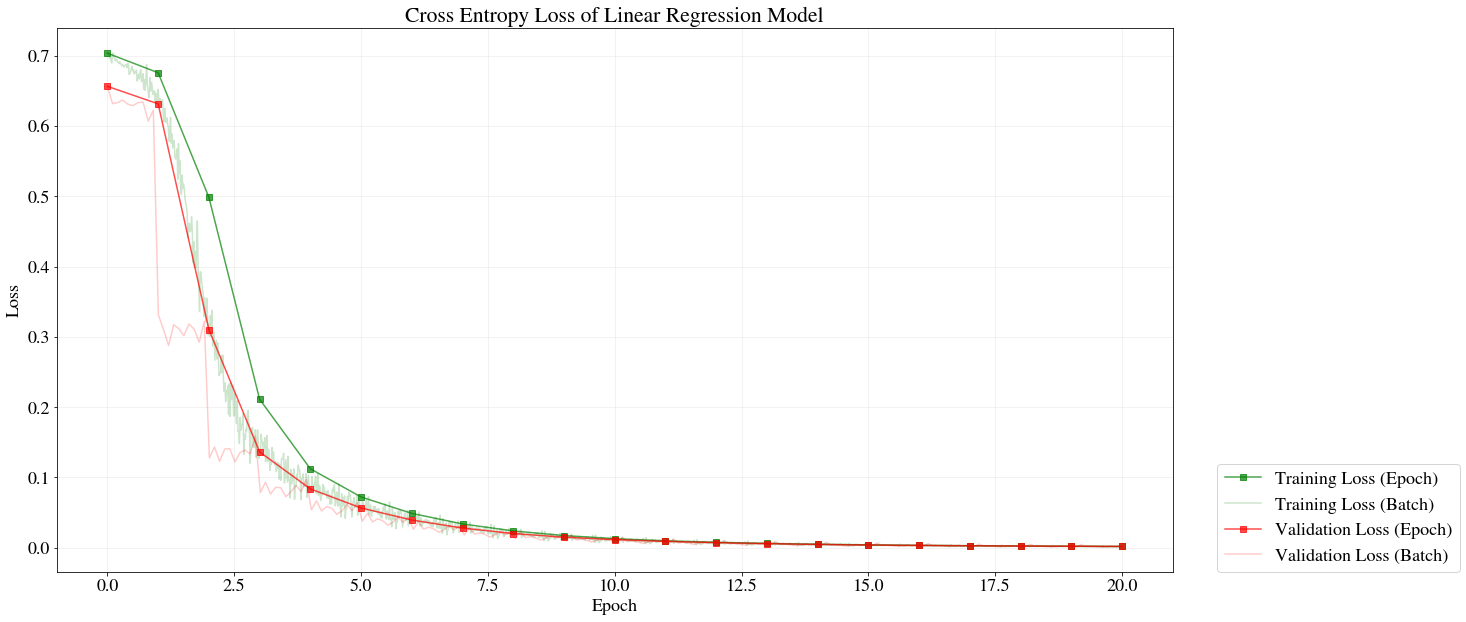

In [52]:
conf.early_stopping = True
conf.max_epochs = 20
conf.dropout = 0.
loss_function = nn.CrossEntropyLoss()

trn_loss = []
val_loss = []
val_loss_best = float("inf")

all_trn_loss = []
all_val_loss = []

# SET MODEL PARAMS
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]

# input_size = hidden_size = np.sum([spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]])
# model = SimpleFNN(input_size, hidden_size)

spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]
# model = KangFeedForwardNetwork(spc_size=spc_size, tmp_size=tmp_size, env_size=env_size, dropout_p=conf.dropout)
model = SmallKangFNN(spc_size=spc_size, tmp_size=tmp_size, env_size=env_size, dropout_p=conf.dropout)

model.to(device)

# parameters = model.parameters()

parameters = [
                {'params': model.spcNet.parameters(), 'lr': 1e-3},    
                {'params': model.tmpNet.parameters(), 'lr': 1e-3},    
                {'params': model.envNet.parameters(), 'lr': 1e-3},
                {'params': model.finalNet.parameters(), 'lr': 1e-3}
            ]


# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

for epoch in range(conf.max_epochs):
    log.info(f"Epoch: {(1+epoch):04d}/{conf.max_epochs:04d}")
    timer.reset()
    # Training loop
    tmp_trn_loss = []
    num_batches = loaders.train_loader.num_batches
    for indices, spc_feats, tmp_feats, env_feats, targets in loaders.train_loader:
        current_batch = loaders.train_loader.current_batch
        
        # Transfer to PyTorch Tensor and GPU
        spc_feats = torch.Tensor(spc_feats[0]).to(device) # only taking [0] for fnn
        tmp_feats = torch.Tensor(tmp_feats[0]).to(device) # only taking [0] for fnn
        env_feats = torch.Tensor(env_feats[0]).to(device) # only taking [0] for fnn
        targets = torch.LongTensor(targets[0,:,0]).to(device) # only taking [0] for fnn
        out = model(spc_feats, tmp_feats, env_feats)
        loss = loss_function(input=out, target=targets)
        tmp_trn_loss.append(loss.item())
        all_trn_loss.append(tmp_trn_loss[-1])

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {tmp_trn_loss[-1]:.4f}")

    trn_loss.append(np.mean(tmp_trn_loss))
    log.debug(f"Epoch {epoch} -> Training Loop Duration: {timer.check()}")
    timer.reset()

    # Validation loop
    tmp_val_loss = []
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        for indices, spc_feats, tmp_feats, env_feats, targets in loaders.validation_loader:
            # Transfer to GPU
            spc_feats = torch.Tensor(spc_feats[0]).to(device)  # only taking [0] for fnn
            tmp_feats = torch.Tensor(tmp_feats[0]).to(device)  # only taking [0] for fnn
            env_feats = torch.Tensor(env_feats[0]).to(device)  # only taking [0] for fnn
            targets = torch.LongTensor(targets[0,:,0]).to(device)  # only taking [0] for fnn
            out = model(spc_feats, tmp_feats, env_feats)

            loss = loss_function(input=out, target=targets)
            tmp_val_loss.append(loss.item())
            all_val_loss.append(tmp_val_loss[-1])

    val_loss.append(np.mean(tmp_val_loss))
    log.debug(f"Epoch {epoch} -> Validation Loop Duration: {timer.check()}")

    log.info(f"\tLoss (Trn): \t{trn_loss[-1]:.5f}")
    log.info(f"\tLoss (Val): \t{val_loss[-1]:.5f}")
    log.info(f"\tLoss (Dif): \t{np.abs(val_loss[-1]-trn_loss[-1]):.5f}\n")        
    

    # save best model
    if min(val_loss) < val_loss_best:
        val_loss_best = min(val_loss)
        torch.save(model.state_dict(), model_path + "model_best.pth")
        torch.save(optimiser.state_dict(), model_path + "optimiser_best.pth")

#     # model has been over-fitting stop maybe? # average of val_loss has increase - starting to over-fit
#     if conf.early_stopping and epoch > 5 and np.sum(np.diff(val_loss[-5:])) > 0:  # increasing moving average
#         log.warning("Early stopping: Over-fitting has taken place")
#         break
        
#     if conf.early_stopping and epoch > 1 and np.abs(val_loss[-1]-val_loss[-2]) < conf.tolerance:
#         log.warning("Converged: Difference between the past two validation losses is within tolerance")
#         break

    # checkpoint - save models and loss values
    torch.save(model.state_dict(), model_path + "model.pth")
    torch.save(optimiser.state_dict(), model_path + "optimiser.pth")
    np.savez_compressed(model_path + "losses.npz",
                        all_val_loss=all_val_loss,
                        val_loss=val_loss,
                        trn_loss=trn_loss,
                        all_trn_loss=all_trn_loss,
                        val_loss_best=val_loss_best)
    
# Save training and validation plots
skip = 0
loss_plotter = LossPlotter(title="Cross Entropy Loss of Linear Regression Model")
loss_plotter.plot_losses(trn_loss, all_trn_loss[skip:], val_loss, all_val_loss[skip:])
loss_plotter.savefig(model_path + "plot_train_val_loss.png")    

In [103]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

n_samples = 10
n_classes = 5
batch_size = 2

batches = []
for batch in range(batch_size):
    input_data = np.random.randint(0,n_classes,size=(n_samples,1))
    ohe = OneHotEncoder(n_values=n_classes,sparse=False)
    out = ohe.fit_transform(input_data)
    batches.append(out)
    target_batches.append(out[0])
    
output_data = np.swapaxes(np.array(batches), 0, -1)
output_data.shape

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


(5, 10, 2)

In [120]:
a = [0,1]
a[-2]

0

# ---------------------------- TESTING END ----------------------------

In [ ]:
# SET MODEL PARAMS
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]

model = KangFeedForwardNetwork(spc_size=spc_size, tmp_size=tmp_size, env_size=env_size, dropout_p=conf.dropout)
model.to(device)

In [ ]:
loss_function = nn.CrossEntropyLoss()

trn_loss = []
val_loss = []
val_loss_best = float("inf")

all_trn_loss = []
all_val_loss = []

optimiser = optim.Adam(params=model.parameters(), lr=conf.lr, weight_decay=conf.weight_decay)
if conf.resume:
    # load model and optimiser states
    model_state_dict = torch.load(model_path + "model_best.pth", map_location=device.type)
    model.load_state_dict(model_state_dict)
    optimiser_state_dict = torch.load(model_path + "optimiser_best.pth", map_location=device.type)
    optimiser.load_state_dict(optimiser_state_dict)
    # load losses
    losses_zip = np.load(model_path + "losses.npz")
    all_val_loss = losses_zip["all_val_loss"].tolist()
    val_loss = losses_zip["val_loss"].tolist()
    trn_loss = losses_zip["trn_loss"].tolist()
    all_trn_loss = losses_zip["all_trn_loss"].tolist()
    val_loss_best = float(losses_zip["val_loss_best"])
    # todo only load loss since last best_checkpoint

In [ ]:
indices, spc_feats, tmp_feats, env_feats, targets = next(iter(loaders.validation_loader))
for i in [indices, spc_feats, tmp_feats, env_feats, targets]:
    print(np.shape(i))

In [ ]:
d = loaders.validation_loader.dataset

indices, spc_feats, tmp_feats, env_feats, targets = d[d.min_index:d.min_index+10]
for i in [indices, spc_feats, tmp_feats, env_feats, targets]:
    print(np.shape(i),end='')

In [ ]:
for (j,(indices, spc_feats, tmp_feats, env_feats, targets)) in enumerate(loaders.validation_loader):
    for i in [indices, spc_feats, tmp_feats, env_feats, targets]:
        print(np.shape(i),end='')
    print(j)  
    break

In [ ]:
for epoch in range(10):#conf.max_epochs):
    log.info(f"Epoch: {(1+epoch):04d}/{conf.max_epochs:04d}")
    timer.reset()
    # Training loop
    tmp_trn_loss = []
    num_batches = loaders.train_loader.num_batches
    for indices, spc_feats, tmp_feats, env_feats, targets in loaders.train_loader:
        current_batch = loaders.train_loader.current_batch
        
        # Transfer to PyTorch Tensor and GPU
        spc_feats = torch.Tensor(spc_feats[0]).to(device) # only taking [0] for fnn
        tmp_feats = torch.Tensor(tmp_feats[0]).to(device) # only taking [0] for fnn
        env_feats = torch.Tensor(env_feats[0]).to(device) # only taking [0] for fnn
        targets = torch.LongTensor(targets[0,:,0]).to(device) # only taking [0] for fnn
        out = model(spc_feats, tmp_feats, env_feats)
        loss = loss_function(input=out, target=targets)
        tmp_trn_loss.append(loss.item())
        all_trn_loss.append(tmp_trn_loss[-1])

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {tmp_trn_loss[-1]:.4f}")

    trn_loss.append(np.mean(tmp_trn_loss))
    log.debug(f"Epoch {epoch} -> Training Loop Duration: {timer.check()}")
    timer.reset()

    # Validation loop
    tmp_val_loss = []
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        for indices, spc_feats, tmp_feats, env_feats, targets in loaders.validation_loader:
            # Transfer to GPU
            spc_feats = torch.Tensor(spc_feats[0]).to(device)  # only taking [0] for fnn
            tmp_feats = torch.Tensor(tmp_feats[0]).to(device)  # only taking [0] for fnn
            env_feats = torch.Tensor(env_feats[0]).to(device)  # only taking [0] for fnn
            targets = torch.LongTensor(targets[0,:,0]).to(device)  # only taking [0] for fnn
            out = model(spc_feats, tmp_feats, env_feats)

            loss = loss_function(input=out, target=targets)
            tmp_val_loss.append(loss.item())
            all_val_loss.append(tmp_val_loss[-1])

    val_loss.append(np.mean(tmp_val_loss))
    log.debug(f"Epoch {epoch} -> Validation Loop Duration: {timer.check()}")

    log.info(f"\tLoss (Trn): \t{trn_loss[-1]:.5f}")
    log.info(f"\tLoss (Val): \t{val_loss[-1]:.5f}")
    log.info(f"\tLoss (Dif): \t{np.abs(val_loss[-1]-trn_loss[-1]):.5f}\n")        
    

    # save best model
    if min(val_loss) < val_loss_best:
        val_loss_best = min(val_loss)
        torch.save(model.state_dict(), model_path + "model_best.pth")
        torch.save(optimiser.state_dict(), model_path + "optimiser_best.pth")

    # model has been over-fitting stop maybe? # average of val_loss has increase - starting to over-fit
    if conf.early_stopping and epoch != 0 and val_loss[-1] > val_loss[-2]:
        log.warning("Over-fitting has taken place - stopping early")
        break
        
    # look into convergence as well - if the running mean is within tolerance for more than 3 epochs stop    

    # checkpoint - save models and loss values
    torch.save(model.state_dict(), model_path + "model.pth")
    torch.save(optimiser.state_dict(), model_path + "optimiser.pth")
    np.savez_compressed(model_path + "losses.npz",
                        all_val_loss=all_val_loss,
                        val_loss=val_loss,
                        trn_loss=trn_loss,
                        all_trn_loss=all_trn_loss,
                        val_loss_best=val_loss_best)

In [ ]:
# Save training and validation plots
skip = 0
loss_plotter = LossPlotter(title="Cross Entropy Loss of Linear Regression Model")
loss_plotter.plot_losses(trn_loss, all_trn_loss[skip:], val_loss, all_val_loss[skip:])
loss_plotter.savefig(model_path + "plot_train_val_loss.png")

# todo evaluation prediction formating into an actual map

In [ ]:
targets = loaders.data_group.testing_set.targets

# todo get better name
probas_grid = np.zeros_like(targets)

In [ ]:

###### testing ###### torch outputs to see if we're actually getting valuable things out
out = torch.Tensor([[-3,2],[2,-1],[0.5,0.4]])
print(out.shape)
print(out)
out_soft = F.softmax(out, dim=-1)
print(out_soft)
out_label = torch.argmax(out_soft, dim=-1)
print(out_label)



In [ ]:
model.load_state_dict(torch.load(model_path + "model_best.pth"))
conf = BaseConf(conf_dict=conf_dict)
conf.batch_size = 4
loaders = FlatDataLoaders(data_path=data_path, conf=conf)

# EVALUATE MODEL
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    
    
    # loop through is set does not fit in batch
    for indices, spc_feats, tmp_feats, env_feats, targets in loaders.test_loader: 
        """
        IMPORTNANT NOTE: WHEN DOING LSTM - ONLY FEED THE TEMPORAL VECTORS IN THE LSTM
        FEED THE REST INTO THE NORMAL LINEAR NETWORKS
        """
        
        
        # Transfer to GPU
        spc_feats = torch.Tensor(spc_feats).to(device)
        tmp_feats = torch.Tensor(tmp_feats).to(device)
        env_feats = torch.Tensor(env_feats).to(device)
        targets = torch.LongTensor(targets).to(device)
        
        y_true.extend(targets.tolist())
        out = model(spc_feats, tmp_feats, env_feats)
        
        
        
        out = F.softmax(out, dim=-1)
        
        log.info(f"out: {out}")
        log.info(f"indices: {indices}")
        log.info(f"indices: {targets}")
    
        out_label = torch.argmax(out, dim=-1)
        log.info(f"out_label: {out_label}")
        y_pred.extend(out_label.tolist())
        out_proba = out[:, 1]  # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())
        
        break  # !! remove


# todo change to be the shape (N,L) of the original prediction.        
model_result = ModelResult(model_name="FNN (Kang and Kang)",
                            y_true=y_true,
                            y_pred=y_pred,
                            probas_pred=probas_pred,
                            t_range=loaders.test_loader.dataset.t_range,
                            shaper=loaders.data_group.shaper)
                        
# log.info(model_result)

np.savez_compressed(model_path + "evaluation_results.npz", model_result)


In [ ]:
pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
roc_plotter.savefig(model_path + "plot_roc_curve.png")

info["stop_time"] = strftime("%Y-%m-%dT%H:%M:%S")
write_json(info, model_path + "info.json")

log.info("=====================================END=====================================")targets.shape